# Imports

In [ ]:
# Libraries
!pip install tensorflow
!pip install keras
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, GRU, LSTMCell
from keras.layers import Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Dropout, Conv3D
import warnings
warnings.filterwarnings('ignore')

# Preparing data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
file_path = '/gdrive/MyDrive/BharatBench/IMDAA_merged_1.08_1990_2020.nc'
data=  xr.open_dataset(file_path)
data

In [ ]:
var_name = ['HGT_prl', 'TMP_prl', 'TMP_2m', 'APCP_sfc'] # [H500, T850, T2m, TP6h]

In [ ]:
ds = data['TMP_prl']
ds = ds.to_dataset()
ds

In [ ]:
# training dataset selection
train_years = slice('1990', '2017')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('2018', '2018')
# test dataset selection
test_years = slice('2019', '2020')
# prediction days ahead
lead_time_steps = 20 # consider the number of observations per day

# Defining Functions

In [ ]:
def get_train_valid_test_dataset(lead_steps, Data_array):
  # Split train, valid and test dataset
  train_data = Data_array.sel(time=train_years)
  valid_data = Data_array.sel(time=valid_years)
  test_data = Data_array.sel(time=test_years)

  # Normalize the data using the mean and standard deviation of the training data
  # mean = train_data.mean(dim = "time")
  # std = train_data.std(dim = "time")

  mean = train_data.mean()
  std = train_data.std()

  train_data = (train_data - mean) / std
  valid_data = (valid_data - mean) / std
  test_data = (test_data - mean) / std

  # Create inputs and outputs that are shifted by lead_steps
  X_train = train_data[list(Data_array)[0]].isel(time=slice(None, -lead_steps)).values[..., None]
  Y_train = train_data[list(Data_array)[0]].isel(time=slice(lead_steps, None)).values[..., None]
  X_valid = valid_data[list(Data_array)[0]].isel(time=slice(None, -lead_steps)).values[..., None]
  Y_valid = valid_data[list(Data_array)[0]].isel(time=slice(lead_steps, None)).values[..., None]
  X_test = test_data[list(Data_array)[0]].isel(time=slice(None, -lead_steps)).values[..., None]
  Y_test = test_data[list(Data_array)[0]].isel(time=slice(lead_steps, None)).values[..., None]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

In [ ]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, ds)

In [ ]:
def compute_rmse(prediction, actual,  mean_dims = ('time', 'latitude', 'longitude')):
  error = prediction - actual
  rmse = np.sqrt(((error)**2 ).mean(mean_dims))
  return rmse

In [ ]:
def compute_mae(prediction, actual, mean_dims = ('time', 'latitude', 'longitude')):
    error = prediction - actual
    mae = np.abs(error).mean(mean_dims)
    return mae

In [ ]:
def compute_acc(prediction, actual):
    clim = actual.mean('time')
    try:
        t = np.intersect1d(prediction.time, actual.time)
        pred_anomaly = prediction.sel(time=t) - clim
    except AttributeError:
        t = actual.time.values
        pred_anomaly = prediction - clim
    act_anomaly = actual.sel(time=t) - clim

    pred_norm = pred_anomaly - pred_anomaly.mean()
    act_norm = act_anomaly - act_anomaly.mean()

    acc = (
            np.sum(pred_norm * act_norm) /
            np.sqrt(
                np.sum(pred_norm ** 2) * np.sum(act_norm ** 2)
            )
    )
    return acc

# CNN

## Building Model

In [17]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    # keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    keras.layers.MaxPooling2D(),

    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(32, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('swish'),
    keras.layers.UpSampling2D(),
    # keras.layers.BatchNormalization(),

    keras.layers.Conv2D(1, 5, padding='same'),

    # No activation since we are solving a regression problem
])

In [20]:
model.build(X_train[:32].shape)
model.compile(keras.optimizers.Adam(learning_rate=4.0), 'mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (32, 32, 32, 32)            │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 32, 32, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (32, 32, 32, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 16, 16, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 16, 16, 32)            │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (32, 16, 16, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (32, 16, 16, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 8, 8, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 8, 8, 32)              │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (32, 8, 8, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (32, 8, 8, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 4, 4, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 4, 4, 32)              │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (32, 4, 4, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (32, 4, 4, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 2, 2, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 2, 2, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 2, 2, 32)              │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (32, 2, 2, 32)              │             128 │
│ (BatchNormalization)                 │                             │              

 Total params: 182,081 (711.25 KB)

 Trainable params: 181,569 (709.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [21]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
def fit_model(model):

    history = model.fit(X_train, Y_train, epochs = 10,
                        validation_data= (X_valid, Y_valid) ,
                        batch_size = 32, shuffle = False,
                        callbacks = [early_stop])
    return history
history_cnn = fit_model(model)

Epoch 1/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 415149.0625 - val_loss: 17.9548
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 11.5955 - val_loss: 4.8443
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 5.0319 - val_loss: 5.2563
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 2.5509 - val_loss: 2.5324
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 1.7404 - val_loss: 6.8711
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.5155 - val_loss: 2.6901
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.1429 - val_loss: 6.0108
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 53611.7852 - val_loss: 15453925099949785088.0000
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 415.5570 - val_loss: 0.9494
Epoch 10/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.1082 - val_loss: 0.9475


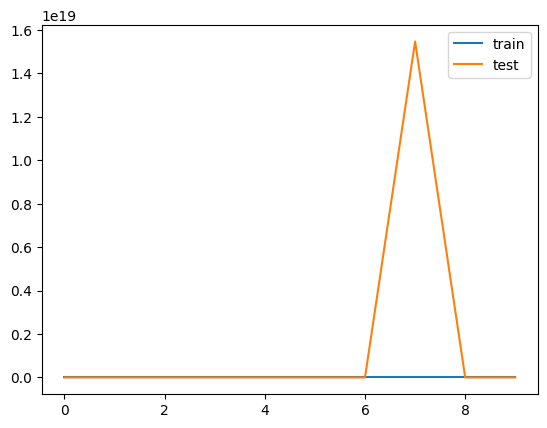

In [22]:
# plot training history
# print("Values stored in history are ... \n", history_cnn.history)
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluation of the Model

In [23]:
target = ds.sel(time=test_years)
# Convert predictions backto xarray
pred_test = X_test[:, :, :, 0].copy()
pred_test[:] = model.predict(X_test).squeeze()

# Unnormalize
pred_result = pred_test*std.TMP_prl.values + mean.TMP_prl.values
pred_result  = xr.DataArray(pred_result, dims=target.isel(time=slice(lead_time_steps, None)).dims, coords=target.isel(time=slice(lead_time_steps, None)).coords)
# compute RMSE
print('RMSE:', compute_rmse(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('MAE', compute_mae(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('ACC', compute_acc(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
RMSE: 5.9156923
MAE 3.9817748
ACC 0.0003533273
